In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv        #csv格式处理模块
from statsmodels.tsa.stattools import adfuller, arma_order_select_ic     #adf检测，ARMA阶次选择
from statsmodels.stats.diagnostic import acorr_ljungbox, acorr_breusch_godfrey, acorr_lm     #自相关检测
from statsmodels.tsa.arima_model import ARMA      #ARMA模型
from statsmodels.graphics.api import qqplot       #分布分位数分布图
import warnings    #是所有警告类的基类。它是异常的子类。
warnings.filterwarnings("ignore")

In [2]:
#载入数据文件，使用pandas.read_csv()函数
filename = 'china-gdp-gross-domestic-product.csv'
pd_data = pd.read_csv(filename, header=1)
pd_data.head()

,date,GDP ( Billions of US $),Per Capita (US $),Annual % Change
0,1960/12/31,59.716468,89.5205,NaN
1,1961/12/31,50.056869,75.8058,-27.27
2,1962/12/31,47.209359,70.9094,-5.58
3,1963/12/31,50.706800,74.3136,10.30
4,1964/12/31,59.708343,85.4986,18.18


In [3]:
#输出DataFrame中column的名称
pd_data.keys()

Index(['date', ' GDP ( Billions of US $)', ' Per Capita (US $)',
       ' Annual % Change'],
      dtype='object')

In [4]:
#每个样本的date字符串只取其年份（前四位字符）
for i in range(len(pd_data)):
    pd_data.iloc[i,0] = pd_data.iloc[i,0][0:4]
#显示前几位数据
pd_data.head()

,date,GDP ( Billions of US $),Per Capita (US $),Annual % Change
0,1960,59.716468,89.5205,NaN
1,1961,50.056869,75.8058,-27.27
2,1962,47.209359,70.9094,-5.58
3,1963,50.706800,74.3136,10.30
4,1964,59.708343,85.4986,18.18


In [5]:
#将date特征作为每个样本的序号
pd_data = pd_data.set_index('date')
pd_data.head()

,GDP ( Billions of US $),Per Capita (US $),Annual % Change
date,,,
1960,59.716468,89.5205,NaN
1961,50.056869,75.8058,-27.27
1962,47.209359,70.9094,-5.58
1963,50.706800,74.3136,10.30
1964,59.708343,85.4986,18.18


In [6]:
#取' GDP ( Billions of US $)'该列新建一个pandas中的Series()数据结构
GDP_series = pd_data[' GDP ( Billions of US $)']
GDP_series.head(5)

date
1960    59.716468
1961    50.056869
1962    47.209359
1963    50.706800
1964    59.708343
Name:  GDP ( Billions of US $), dtype: float64

# 平稳时间序列模型<p>
这里的平稳是指宽平稳，其特性是序列的统计特性不随时间的平移而变化，即均值和协方差不随时间的平移而变化。<p>
下面的程序中，做 *log* 和 *差分* 就是为了消除数据趋势。<p>
我们使用**ARMA模型**对时间序列进行简单预测

## 数据的预处理以及平稳性和自相关检测

In [7]:
def test_stationarity(timeseries):
    
    #滑动均值和方差
    rolmean = timeseries.rolling(4).mean()
    rolstd = timeseries.rolling(4).std()

    #绘制滑动统计量
    plt.figure(figsize=(24, 8))   
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #adf检验(序列的平稳性测试)
    print('Results of Augmented Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    #通过创建一个Series类型，格式化adf输出
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used',
                                             'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #自相关检测 lm
    lm_test = acorr_lm(timeseries)
    print('Results of LM Test:')
    lmoutput = pd.Series(lm_test, index=['Lagrange multiplier test statistic','The p-value for Lagrange multiplier test',
                                        'The f statistic of the F test','The p-value of the F test.'])
    print(lmoutput)

In [8]:
#不格式化输出时的输出结果,观察p-values，越小越好如果小于0.05，可以认为序列是平稳的
dftest = adfuller(GDP_series, autolag='AIC')
print(dftest)

(6.466333985522315, 1.0, 9, 50, {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}, 600.8188863196352)


In [9]:
#序列自相关检测 ljungbox方法、lm方法，观察p-values，越小越好如果小于0.05，可以认为序列是有自相关性的（非白噪声）
print(acorr_ljungbox(GDP_series))

print(acorr_lm(GDP_series))

(array([ 52.47068992,  95.45124169, 130.80559746, 159.53890621,
       181.6740108 , 197.911358  , 209.2797299 , 216.843715  ,
       221.58288376, 224.53156251, 226.27344317, 227.15491423,
       227.57271023, 227.75047832, 227.80357619, 227.80728524,
       227.81534111, 227.86900333, 228.00674607, 228.26245632,
       228.66618715, 229.25379825, 230.06337995, 231.12584556,
       232.4541096 , 234.03383358, 235.86029958, 237.96315314]), array([4.36717736e-13, 1.87510772e-21, 3.62628161e-28, 1.83575125e-33,
       2.34908869e-37, 5.28108401e-40, 1.24036825e-41, 1.78754109e-42,
       9.72360311e-43, 1.20220860e-42, 2.54196732e-42, 7.77299397e-42,
       2.84319767e-41, 1.11980717e-40, 4.50481256e-40, 1.79016729e-39,
       6.86718111e-39, 2.49983067e-38, 8.50115725e-38, 2.66465573e-37,
       7.60976389e-37, 1.95221352e-36, 4.43190604e-36, 8.80078292e-36,
       1.52350339e-35, 2.31938254e-35, 3.11849816e-35, 3.66160215e-35]))
(49.971568947560044, 2.7014089163910273e-07, 6854.7979117

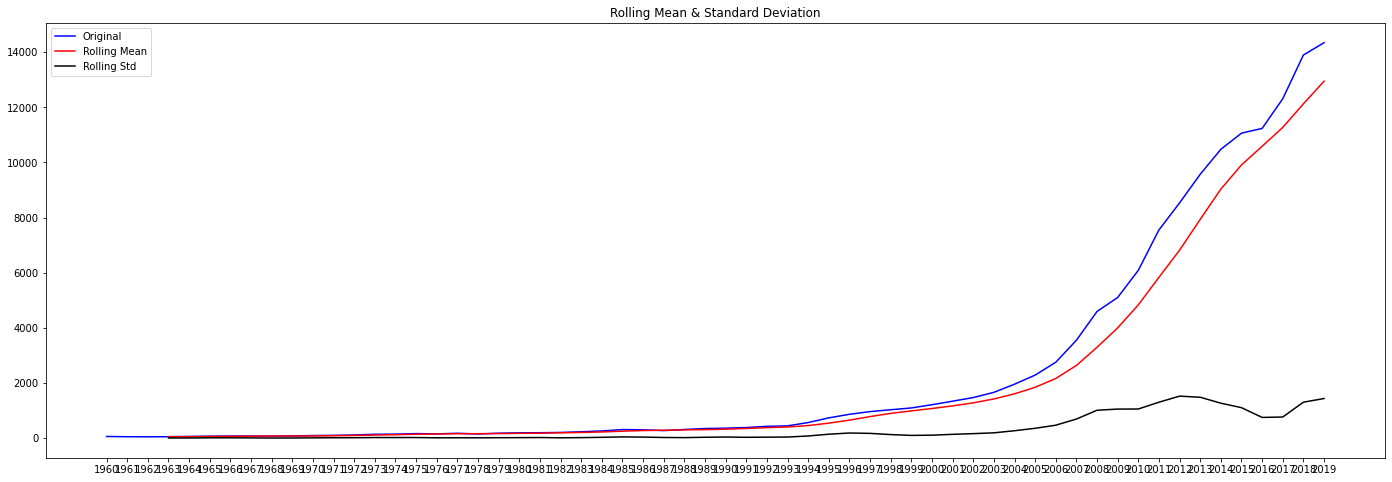

Results of Augmented Dickey-Fuller Test:
Test Statistic                  6.466334
p-value                         1.000000
#Lags Used                      9.000000
Number of Observations Used    50.000000
Critical Value (1%)            -3.568486
Critical Value (5%)            -2.921360
Critical Value (10%)           -2.598662
dtype: float64
Results of LM Test:
Lagrange multiplier test statistic          4.997157e+01
The p-value for Lagrange multiplier test    2.701409e-07
The f statistic of the F test               6.854798e+03
The p-value of the F test.                  5.073863e-60
dtype: float64


In [10]:
#原序列稳定性测试
test_stationarity(GDP_series)

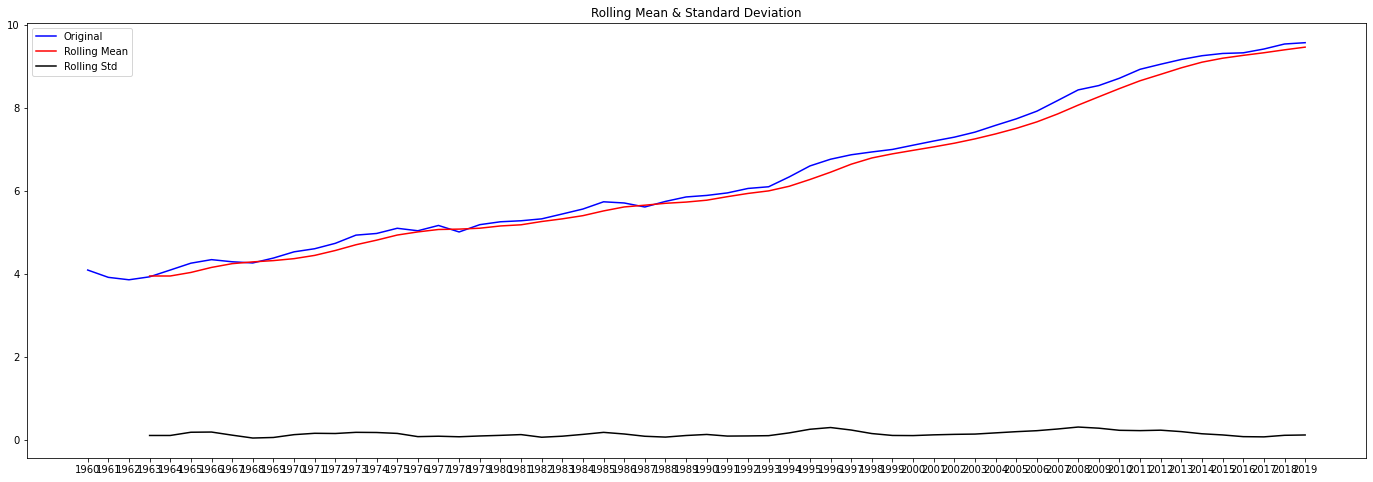

Results of Augmented Dickey-Fuller Test:
Test Statistic                  2.110614
p-value                         0.998801
#Lags Used                      0.000000
Number of Observations Used    59.000000
Critical Value (1%)            -3.546395
Critical Value (5%)            -2.911939
Critical Value (10%)           -2.593652
dtype: float64
Results of LM Test:
Lagrange multiplier test statistic          5.884814e+01
The p-value for Lagrange multiplier test    1.703230e-14
The f statistic of the F test               2.208792e+04
The p-value of the F test.                  1.677865e-75
dtype: float64


In [11]:
#其对数序列的稳定性测试
GDP_log = np.log(GDP_series)
test_stationarity(GDP_log)

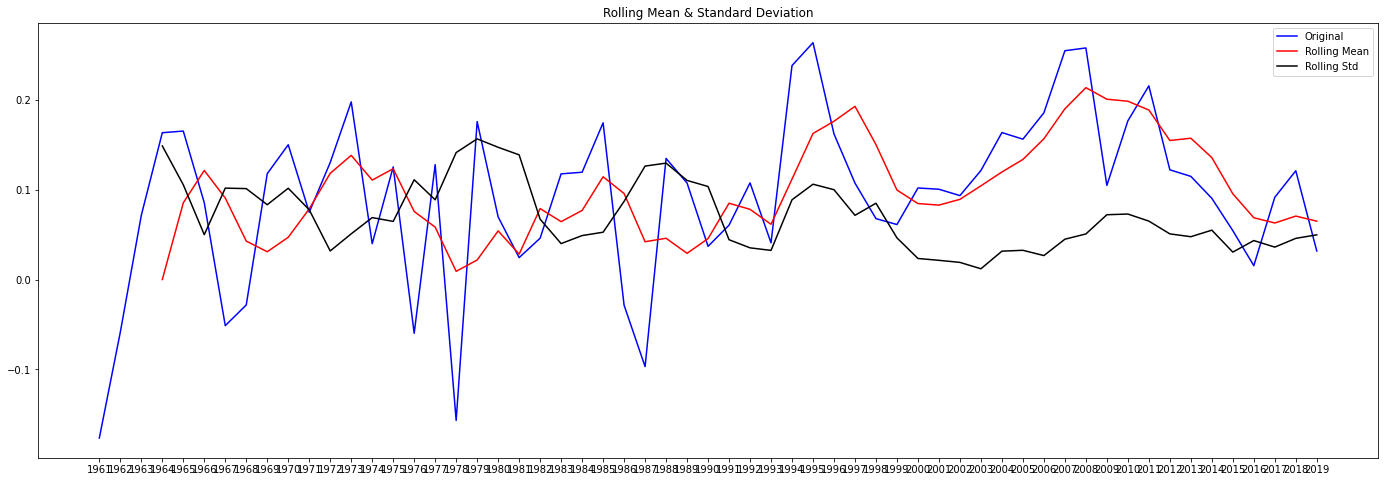

Results of Augmented Dickey-Fuller Test:
Test Statistic                -6.173999e+00
p-value                        6.698891e-08
#Lags Used                     0.000000e+00
Number of Observations Used    5.800000e+01
Critical Value (1%)           -3.548494e+00
Critical Value (5%)           -2.912837e+00
Critical Value (10%)          -2.594129e+00
dtype: float64
Results of LM Test:
Lagrange multiplier test statistic          4.887679
The p-value for Lagrange multiplier test    0.027049
The f statistic of the F test               5.153418
The p-value of the F test.                  0.027069
dtype: float64


In [12]:
#差分对数序列的稳定性测试
GDP_log_diff1=GDP_log.diff(1)
GDP_log_diff1.dropna(inplace=True)
test_stationarity(GDP_log_diff1)

In [13]:
#差分后，数据的序号发生了一些改变（对比GDP_series）
GDP_log_diff1.index

Index(['1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969',
       '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978',
       '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987',
       '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996',
       '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005',
       '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014',
       '2015', '2016', '2017', '2018', '2019'],
      dtype='object', name='date')

## 定阶：判断模型阶数

In [14]:
#信息准则定阶
order = arma_order_select_ic(GDP_log_diff1,max_ar=6,max_ma=6,ic=['aic', 'bic', 'hqic'])

## 创建ARMA模型

In [15]:
#查看 'AIC' 准则中的最小阶次
print(order.aic_min_order)
#根据阶次建立ARMA模型，并训练
model = ARMA(GDP_log_diff1,order.aic_min_order).fit()
#输出训练后模型的结果
print(model.summary2())
print(model.pvalues) #T检验p值

(1, 0)
                               Results: ARMA
Model:              ARMA                    BIC:                 -107.4589 
Dependent Variable: GDP ( Billions of US $) Log-Likelihood:      59.846    
Date:               2021-04-21 18:22        Scale:               1.0000    
No. Observations:   59                      Method:              css-mle   
Df Model:           2                       Sample:              01-01-1961
Df Residuals:       57                                           01-01-2019
Converged:          1.0000                  S.D. of innovations: 0.088     
No. Iterations:     14.0000                 HQIC:                -111.259  
AIC:                -113.6915                                              
---------------------------------------------------------------------------
                                Coef.  Std.Err.   t    P>|t|  [0.025 0.975]
---------------------------------------------------------------------------
const                           0.09

## 检验模型的效果

<Figure size 432x288 with 0 Axes>

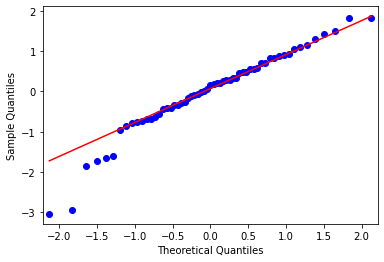

In [16]:
#根据预测与真实值的残差画QQ图
resid = model.resid  #model中包含残差属性（resid）
fig = plt.figure() #figsize=(6,6)
# Q-Q plot of the quantiles of x versus the quantiles/ppf of a distribution.
fig = qqplot(resid, line='q', fit=True)
plt.show()

In [17]:
#检验残差的自相关性
print(acorr_breusch_godfrey(model))
print(acorr_lm(model.resid))
#有点没搞清楚的地方：为何得到的结果不同，是不是算法中还是有一些区别？

(5.965403565579844, 0.8181614592079183, 0.5399105308586722, 0.8530217170588694)
(0.19367260651338247, 0.6598773563911333, 0.18762074073523552, 0.6665681319237999)


In [42]:
#拟合优度检验
prediction_tmp = model.predict(start='1961', end='2019')
ssr = ((prediction_tmp-GDP_log_diff1.mean())**2).sum()
print(ssr)
sse = ((model.resid)**2).sum()
print(sse)
r2 = ssr/ (sse + ssr)
print(r2)

0.047686494561307545
0.46040130251343686
0.09385483145995026


## 绘制图像

<Figure size 432x288 with 0 Axes>

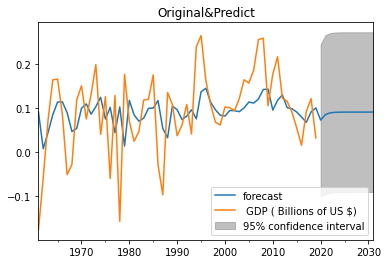

In [18]:
#绘制预测结果和原始数据图
plt.figure()
fig = model.plot_predict('1961', '2031') 
plt.legend(loc='best')
plt.title('Original&Predict')
plt.show()

In [19]:
#统一横坐标轴的label，如果不统一，画图时会出现错误
prediction = model.predict(start='1961', end='2031') #(start='1961', end='2031')
print(prediction.index)
#将prediction中的label进行替换，替换为从‘1961’到‘2032’的字符串（和GDP_series中的一样）
prediction.index = [str(i) for i in range(1961,2032)]
prediction.index.name = 'date'
print(prediction.index)
GDP_log_diff1.index
#print(GDP_log_diff1)

DatetimeIndex(['1961-01-01', '1962-01-01', '1963-01-01', '1964-01-01',
               '1965-01-01', '1966-01-01', '1967-01-01', '1968-01-01',
               '1969-01-01', '1970-01-01', '1971-01-01', '1972-01-01',
               '1973-01-01', '1974-01-01', '1975-01-01', '1976-01-01',
               '1977-01-01', '1978-01-01', '1979-01-01', '1980-01-01',
               '1981-01-01', '1982-01-01', '1983-01-01', '1984-01-01',
               '1985-01-01', '1986-01-01', '1987-01-01', '1988-01-01',
               '1989-01-01', '1990-01-01', '1991-01-01', '1992-01-01',
               '1993-01-01', '1994-01-01', '1995-01-01', '1996-01-01',
               '1997-01-01', '1998-01-01', '1999-01-01', '2000-01-01',
               '2001-01-01', '2002-01-01', '2003-01-01', '2004-01-01',
               '2005-01-01', '2006-01-01', '2007-01-01', '2008-01-01',
               '2009-01-01', '2010-01-01', '2011-01-01', '2012-01-01',
               '2013-01-01', '2014-01-01', '2015-01-01', '2016-01-01',
      

Index(['1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969',
       '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978',
       '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987',
       '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996',
       '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005',
       '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014',
       '2015', '2016', '2017', '2018', '2019'],
      dtype='object', name='date')

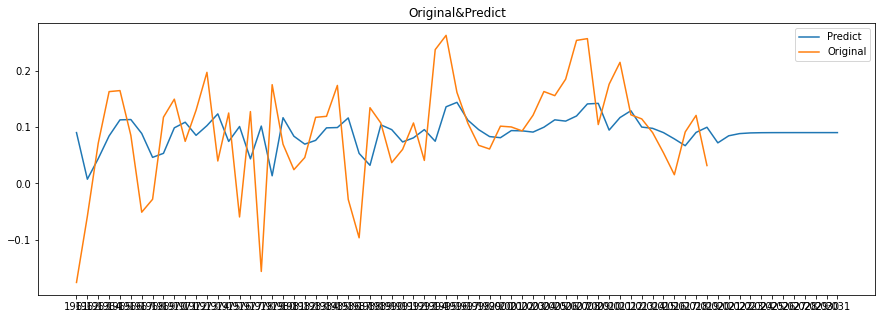

In [20]:
#上图的自己绘制的版本
plt.figure(figsize=(15,5))
plt.plot(prediction,label='Predict')
plt.plot(GDP_log_diff1,label='Original')
plt.legend(loc='best')
plt.title('Original&Predict')
plt.show()

In [21]:
#预测值的样子
prediction

date
1961    0.090414
1962    0.007414
1963    0.044077
1964    0.084522
1965    0.113118
          ...   
2027    0.090409
2028    0.090413
2029    0.090414
2030    0.090414
2031    0.090414
Length: 71, dtype: float64

In [22]:
## 数据还原
# 一阶差分还原
prediction_GDP_log = prediction.add(GDP_log.shift(1))[1:]
prediction_GDP_log['2020'] = prediction['2020']+ GDP_log['2019']
print(prediction_GDP_log['2020'])
for i in range(2021, 2032):
    prediction_GDP_log[str(i)] = prediction[str(i)] + prediction_GDP_log[str(i-1)]
print(prediction_GDP_log)

9.643175541954072
date
1961     4.180022
1962     3.920574
1963     3.898670
1964     4.010582
1965     4.202590
          ...    
2027    10.267840
2028    10.358253
2029    10.448666
2030    10.539081
2031    10.629495
Length: 71, dtype: float64


In [23]:
# 对数还原
prediction_GDP = np.exp(prediction_GDP_log)
prediction_GDP.dropna(inplace=True)
prediction_GDP

date
1961       65.367301
1962       50.429359
1963       49.336766
1964       55.178950
1965       66.859274
            ...     
2027    28791.626244
2028    31516.061866
2029    34498.337841
2030    37762.831105
2031    41336.239778
Length: 71, dtype: float64

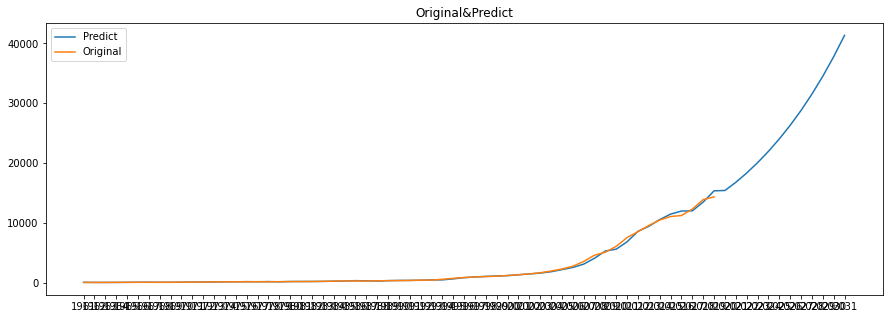

In [24]:
#绘制数据预测图
plt.figure(figsize=(15,5))
plt.plot(prediction_GDP,label='Predict')
plt.plot(GDP_series[1:],label='Original')
plt.legend(loc='best')
plt.title('Original&Predict')
plt.show()

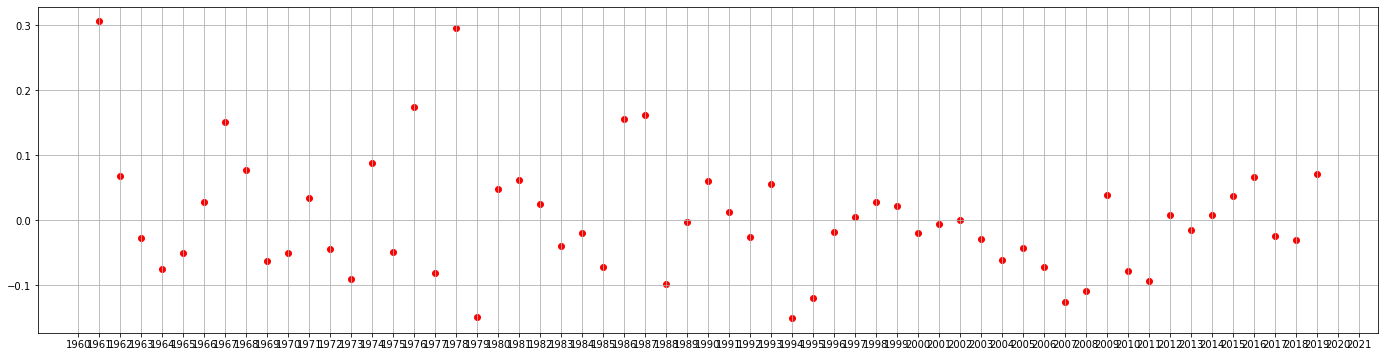

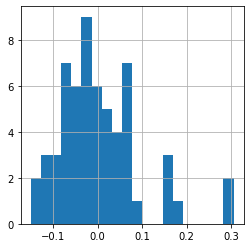

In [25]:
#计算错误率，并绘制散点图 
ERROR_RATE=(prediction_GDP-GDP_series)/GDP_series
plt.figure(figsize=(24, 6))   
plt.scatter(ERROR_RATE.index,ERROR_RATE,color='r')
plt.grid(True)
#绘制错误率直方图
plt.figure(figsize=(4, 4))
plt.hist(ERROR_RATE, bins=20)
plt.grid(True)
plt.show()